In [1]:
%matplotlib notebook
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import sympy as sym
from scipy.integrate import solve_ivp
from scipy import integrate
import matplotlib.pyplot as plt
from tqdm import tqdm 
import matplotlib.animation as anim

# Punto 3
### Gravitational N-Body problem

In [2]:
class Particle():
    
    def __init__(self, r0,v0,a0,t,m,radius,Id):
        
        self.dt = t[1]-t[0]
        
        self.r = r0
        self.v = v0
        self.a = a0
        self.m = m
        self.radius = radius
        self.Id = Id
        self.Ep = 0.
        self.Force = self.m * self.a
        self.G = 4*np.pi**2
        self.epsilon = 0.1
        
        self.L = np.zeros(len(r0))
        self.rVector = np.zeros((len(t),len(r0)))
        self.vVector = np.zeros((len(t),len(v0)))
        self.aVector = np.zeros((len(t),len(a0)))
        
        
        self.MomentumVector = np.zeros((len(t),len(v0)))
        self.AngularMomentumVector = np.zeros((len(t),len(v0)))
        
        
        self.EpVector = np.zeros((len(t),1))
        self.EkVector = np.zeros((len(t),1))
        

        #Pasado de la posición y velocidad de cada n cuerpo
        
        self.rp = r0
        self.vp = v0
        
           
        
    def Evolution(self,i):
        
        self.SetPosition(i,self.r)
        self.SetVelocity(i,self.v)
        self.SetMomentum(i,self.m*self.v)
        
    
        
        self.SetEk(i,self.GetKineticEnergy())
        self.SetEp(i,self.GetPotentialEnergy())
        
        
        self.a = self.Force/self.m
        
        
        # se inicializa con método de Euler
        if i == 0:
            
            
            self.rp = self.r
            self.r = self.rp + self.dt * self.v
        
        else:
            
            #Verlet method
            self.rf = 2*self.r - self.rp + self.a * self.dt**2            
            self.v = ( self.rf - self.rp ) / (2*self.dt)
            
            self.rp = self.r
            self.r = self.rf
        
        
        
     
      
        
  
            
    def ResetForce(self):
        
        self.Force[:] = 0.
        self.a[:] = 0.
        self.Ep = 0.
        
    
    
    # Setters
    
    def SetPosition(self,i,r):
        self.rVector[i] = r
        
    def SetVelocity(self,i,v):
        self.vVector[i] = v   
        
    def SetMomentum(self,i,p):
        self.MomentumVector[i] = p
        
    def SetAngularMomentum(self,i,r,p):
        
    
        self.L[0] = r[1]*p[2] - r[2]*p[1]
        self.L[1] = -(r[0]*p[2] - r[2]*p[0])
        self.L[2] = r[0]*p[1] - r[1]*p[0]
        
        self.AngularMomentumVector[i] = self.L
            
    def SetEk(self,i,Ek):
        self.EkVector[i] = Ek
    
    def SetEp(self,i,Ep):
        self.EpVector[i] = Ep

    
    # Getters
    
    def GetForce(self,p):
        
        d = np.linalg.norm( self.r - p.GetPosition() )
        
        Fnorm = - self.G * self.m * p.m / (d**2+self.epsilon**2)**(3/2)
        
        self.Force = np.add( self.Force, Fnorm* (self.r - p.GetPosition())  )
        
        self.Ep += - self.G * self.m * p.m / d
                
    
    def GetPosition(self):
        return self.r
    
    def GetPositionVector(self):
        return self.rVector
    
    def GetReducePosition(self):
        return self.RrVector
        
    def GetVelocityVector(self):
        return self.vVector    
    
    def GetMomentumVector(self):
        return self.MomentumVector
    
    def GetAngularMomentumVector(self):
        return self.AngularMomentumVector
        
    def GetReduceVelocity(self):
        return self.RvVector
     
    def GetKineticEnergy(self):
        return 0.5*self.m*np.linalg.norm(self.v)**2
    
    def GetPotentialEnergy(self):

        return 0.5*self.Ep 

    def GetR(self):
        return self.radius
  

    def ReduceSize(self,factor):
        
        self.RrVector = np.array([self.rVector[0]])
        
        for i in range(1,len(self.rVector)):
            if i%factor == 0:
                self.RrVector = np.vstack([self.RrVector,self.rVector[i]])
                
        self.RvVector = np.array([self.vVector[0]])
        
        for i in range(1,len(self.vVector)):
            if i%factor == 0:
                self.RvVector = np.vstack([self.RvVector,self.vVector[i]])

In [3]:
def GetParticles(NParticles,Limit,Velo,Dim=3,dt=0.1):
    
    Particles_ = []

    radEsf = Limits[0]
    for i in range(NParticles):
        
        j = 0
        
        while j < 1:
            "Para setear la posición donde estará la partícula \
             se mira que esté dentro del radio de esfera, para \
             ello se coloca la condición de que su norma al cua-\
             drado sea menor o igual al límite o radio de esfera."
            
            x0 = np.random.uniform(-Limit, Limit, size=Dim )
            
            if x0[0]**2 + x0[1]**2 + x0[2]**2 <= radEsf:
                
                r0 = x0
                j = j+1
                
            else:
                
                j=0 
            
            
        v0 = np.array([0.,0.,0.])
        a0 = np.array([0.,0.,0.])
        
        m = 0.01
        p = Particle(r0,v0,a0,t,m,1,i)
        
        Particles_.append(p)
        
        
    return Particles_

In [4]:
#Radio de esfera 1
Limits = np.array([1.,1.,1.]) 

In [5]:
def RunSimulation(t,NParticles = 10, Velo = 6):
    

    Particles = GetParticles(NParticles,Limits[0],Velo = Velo,dt=dt)
      
    for it in tqdm(range(len(t))):
        
        for i in range(len(Particles)):    
            for j in range(len(Particles)):
                if i != j:
                    Particles[i].GetForce(Particles[j])
             
            
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            
        
    return Particles

In [6]:
dt = 0.001
tmax = 2.
t = np.arange(0.,tmax+dt,dt)

In [16]:
Particles = RunSimulation(t,100,Velo = 10)

100%|██████████████████████████████████████████████████████████████████████████████| 2001/2001 [10:04<00:00,  3.31it/s]


In [17]:
K = Particles[0].EkVector
U = Particles[0].EpVector
EnergiaTotal = Particles[0].EkVector + Particles[0].EpVector

for i in range(1,len(Particles)):
    K = np.add(K, Particles[i].EkVector)
    U = np.add(U, Particles[i].EpVector)
    EnergiaTotal = np.add(EnergiaTotal, Particles[i].EkVector + Particles[i].EpVector) 

Momentum = Particles[0].GetMomentumVector()
for i in range(1,len(Particles)):
    Momentum = np.add(Momentum, Particles[i].GetMomentumVector()) 
    
L = Particles[0].GetAngularMomentumVector()
for i in range(1,len(Particles)):
    L = np.add(L, Particles[i].GetAngularMomentumVector())

<IPython.core.display.Javascript object>


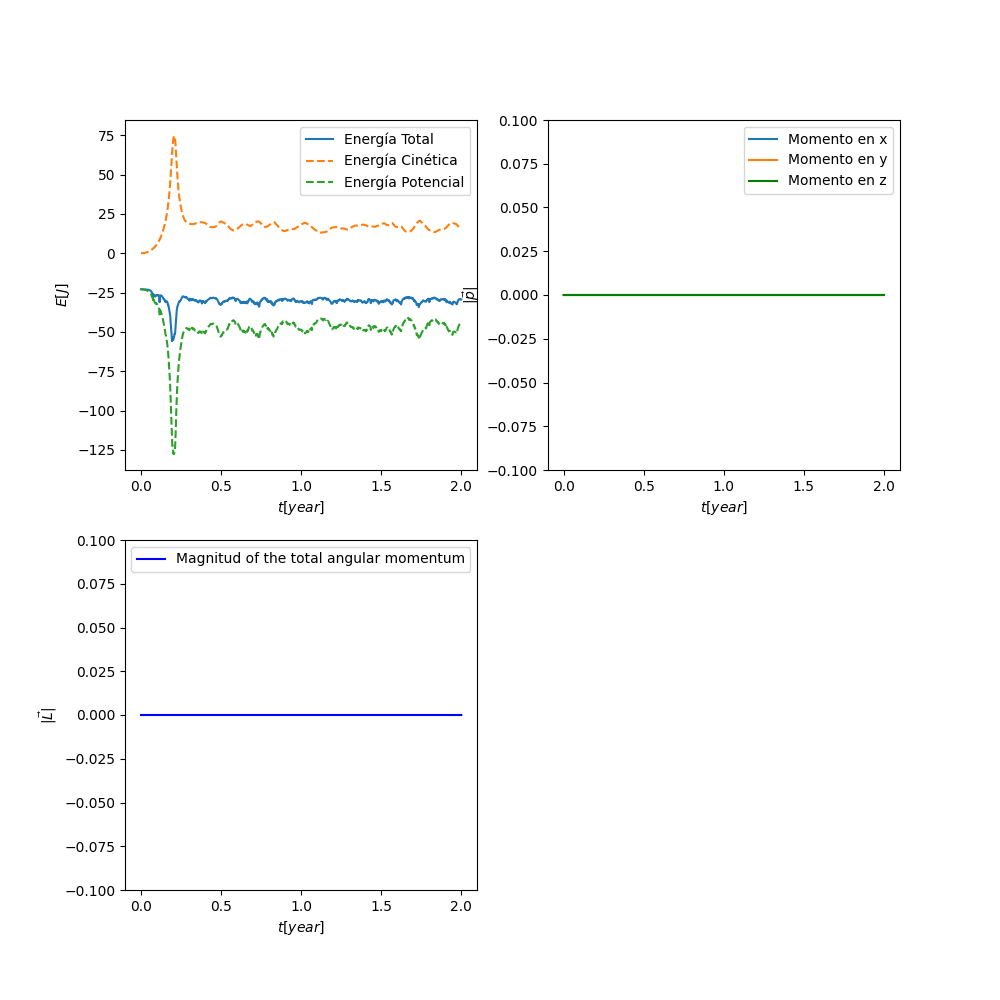

(-0.1, 0.1)

In [18]:
fig1 = plt.figure(figsize=(10,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)
ax3 = fig1.add_subplot(2,2,3)


ax1.plot(t,EnergiaTotal, label='Energía Total')
ax1.plot(t,K,'--',label='Energía Cinética')
ax1.plot(t,U,'--',label='Energía Potencial')
ax1.set_xlabel(r'$t[year]$')
ax1.set_ylabel(r'$E[J]$')
ax1.legend(loc=0)


ax2.plot(t,Momentum[:,0], label='Momento en x')
ax2.plot(t,Momentum[:,1], label='Momento en y')
ax2.plot(t,Momentum[:,2], color = 'g', label='Momento en z')
ax2.set_xlabel(r'$t[year]$')
ax2.set_ylabel(r'$|\vec{p}|$')
ax2.legend(loc=0)
ax2.set_ylim(-0.1,0.1)

ax3.plot(t,L[:,0], color = 'b', label='Magnitud of the total angular momentum')
ax3.set_xlabel(r'$t[year]$')
ax3.set_ylabel(r'$|\vec{L}|$')
ax3.legend(loc=0)
ax3.set_ylim(-0.1,0.1)

In [19]:
def ReduceTime(t,factor):
    
    for p in Particles:
        p.ReduceSize(factor)
    
    Newtime = []
    for i in range(len(t)):
        if i%factor == 0:
            Newtime.append(t[i])
            
    return np.array(Newtime)

In [20]:
redt = ReduceTime(t,100)

<IPython.core.display.Javascript object>


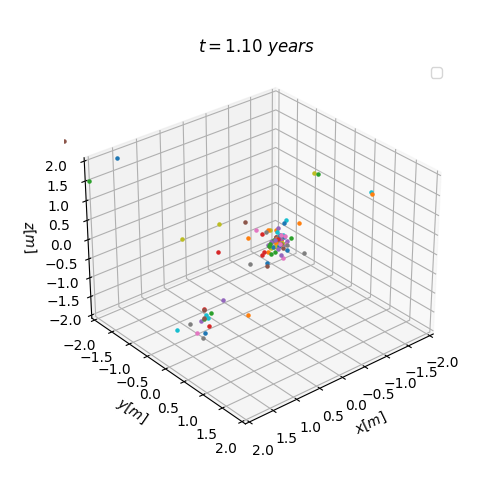

In [21]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1, projection = '3d',elev = 30, azim = 50)
    
def init():
    ax.set_xlabel(r'$x[m]$',fontsize=10)
    ax.set_ylabel(r'$y[m]$',fontsize=10)
    ax.set_zlabel(r'$z[m]$',fontsize=10)
    ax.set_xlim(-Limits[0]-1,Limits[0]+1)
    ax.set_ylim(-Limits[1]-1,Limits[1]+1)
    ax.set_zlim(-Limits[2]-1,Limits[2]+1)


def Update(i):
    
    plot = ax.clear()
    init()
    
    
    
    for p in Particles:
        
        x = p.GetReducePosition()[i,0]
        y = p.GetReducePosition()[i,1]
        z = p.GetReducePosition()[i,2]
        
        
        plot = ax.set_title(r'$t=%.2f \ years$' %(redt[i]))
        
        plot = ax.scatter(x,y,z,marker='.')
        
   
    plot = ax.legend()
            
    return plot
    
Animation = anim.FuncAnimation(fig,Update,frames=len(redt),init_func=init)
